In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import json
import numpy as np
from transformers import AutoTokenizer
from huggingface_hub import login
from scipy.stats import bootstrap
from tqdm.notebook import tqdm
import pickle
import glob

In [2]:
def add_correctness(df, label_list=["A","B"]):
    df["ground_truth"] = df[f"{label_list[0]}_is_first"].apply(lambda x: label_list[::-1][x])
    df["correct"] = df["answer"] == df["ground_truth"]
    return df

def add_p_correct(df, label_list = ["A","B"]):
    p_corrects = [row[1][f"prob_{label_list[0]}"] if row[1][f"ground_truth"]== label_list[0] else row[1][f"prob_{label_list[1]}"] for row in df.iterrows()]
    df["p_correct"] = p_corrects
    return df

def add_excerpt_length(df):
    df["excerpt_length"] = df["data"].apply(lambda x: int(x.split("-")[0]))
    df["segment_length"] = df["data"].apply(lambda x: int(x.split("-")[1].replace("s","")))

    return df


def add_segment_distance(df):
    assert np.all(df['seg1_pos_x'] == df['seg1_pos_y'])
    assert np.all(df['seg2_pos_x'] == df['seg2_pos_y'])
    segment_len = df['segment_length']
    dist = np.abs(df['seg1_pos_x']-df['seg2_pos_x'])-segment_len
    df['segment_dist'] = dist
    return df

def add_distance_bin(df):
    equal_bins,bin_edges = pd.qcut(df['segment_dist'], 18, labels=False,retbins = True)
    df['bin_idx'] = equal_bins
    bin_centers = []
    for i,bin_val in enumerate(bin_edges[:-1]):
        bin_center = np.mean([bin_val,bin_edges[i+1]])
        bin_centers.append(bin_center)
    bin_center_arr = [bin_centers[bin_idx] for bin_idx in equal_bins.values]
    df['bin_center'] = bin_center_arr
    return df
def add_human_distance_bin(df,human):
    if human:
        bins = [0,400,1000,1500,4000,10000,16500,25000,40000]
        bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k','16.5k-25k','25k-40k']
        assert np.all(df['distance_in_whole_book_x'] == df['distance_in_whole_book_y'])
        bin_indices = np.digitize(df['distance_in_whole_book_x'], bins)
    else:
        bins = [0,400,1000,1500,4000,10000,16500]#,25000,40000]
        bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k']
        bin_indices = np.digitize(df['segment_dist'], bins)
    # Adjust bin indices to be 0-based
    bin_indices -= 1
    #bin_indices_strings = [bin_strings[i] for i in bin_indices]
    df['bin_human'] = bin_indices
    return df
def add_human_distance_bin2(df,human):
    if human:
        bins = [0,400,1000,1500,4000,10000,16500,25000,40000]
        bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k','16.5k-25k','25k-40k']
        bin_indices = np.digitize(df['segment_dist'], bins)
    else:
        bins = [0,400,1000,1500,4000,10000,16500]#,25000,40000]
        bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k']
        bin_indices = np.digitize(df['segment_dist'], bins)
    # Adjust bin indices to be 0-based
    bin_indices -= 1
    #bin_indices_strings = [bin_strings[i] for i in bin_indices]
    df['bin_human'] = bin_indices
    return df
# Step 3: Define the helper function
def find_largest_bin(value, bins):
    # Find the largest bin that is greater than the value
    for bin_value in sorted(bins):
        if value < bin_value:
            return bin_value
    return np.max(bins)  # or some default value if needed

def recover_distance_bin(df,human):
    '''recover the original distance bins (same # samples across bins)'''
    original_distance_bins = [1000,2000,10000,20000,15000]
    if 'distance_bin_x' not in df.columns:
        # Step 4: Apply the helper function to the dataframe
        df['distance_bin'] = df['distance_in_whole_book_x'].apply(find_largest_bin, bins=original_distance_bins)
    else:
        df['distance_bin'] = df['distance_bin_x']
    return df

def add_human_distance_bin2(df,human):
    '''bins used to present human data'''
    if human:
        bins = [0,400,1000,1500,4000,10000,16500,25000,40000]
        bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k','16.5k-25k','25k-40k']
        bin_indices = np.digitize(df['segment_dist'], bins)
    else:
        bins = [0,400,1000,1500,4000,10000,16500]#,25000,40000]
        bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k']
        bin_indices = np.digitize(df['segment_dist'], bins)
    # Adjust bin indices to be 0-based
    bin_indices -= 1
    #bin_indices_strings = [bin_strings[i] for i in bin_indices]
    df['bin_human'] = bin_indices
    return df
def add_segment_distance2(df,segment_len):
    if 'seg1_pos_x' in df.columns:
        dist = np.abs(df['seg1_pos_x']-df['seg2_pos_x'])-segment_len
    else:
        dist = np.abs(df['seg1_pos']-df['seg2_pos'])-segment_len
    df['segment_dist'] = dist
    return df
def apply_all(df, model_path_csv, download_dir, label_list=["A","B"], LTM=True,human = False):
    df = add_correctness(df,label_list)
    if human==False:
        df = add_segment_distance(df)
        df = add_distance_bin(df)
    else:
        df = recover_distance_bin(df,human)
        if 'distance_in_whole_book_x' in df.columns:
            df['segment_dist'] = df['distance_in_whole_book_x']
        else:
            df = add_segment_distance2(df,int(segment_lengths[0][1:]))
        df = add_human_distance_bin2(df,human = True)
    return df

In [4]:
os.getcwd()

'/home/jianing/time'

Text(0, 0.5, 'Accuracy')

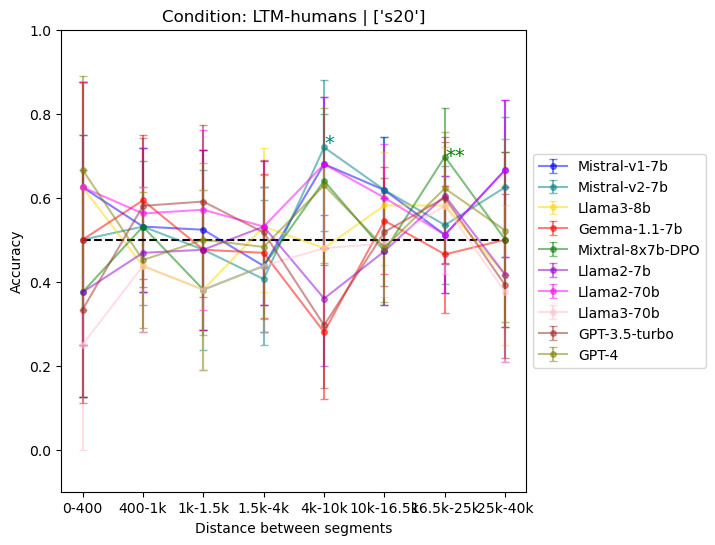

In [3]:
condition = "LTM-humans" # "LTM"
if condition == "LTM-humans":
    download_dir = os.path.join(os.getcwd(),"human-LTM/result")
    bins = [0,400,1000,1500,4000,10000,16500,25000,40000]
    bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k','16.5k-25k','25k-40k']
    data_path = os.path.join(os.getcwd(),"human-LTM/stim","human_segments_fix")
    gpt_data_path = os.path.join(os.getcwd(),"human-LTM/stim")
elif condition == "LTM":
    download_dir=os.path.join(os.getcwd(),"results","LTM")
    bins = [0,400,1000,1500,4000,10000,16500]
    bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k']
    data_path = os.path.join(os.getcwd(),"pgbooks_data_neurips")
plot_feature = 'bin_human' # use "bin_human" for the bin_strings above (eg for LTM figure). Use "distance_bin" for LTM_human equal artificial bins
model_path_csv = os.path.join(os.getcwd(),"recency_judgment_eval/model_paths.csv")
LTM = True if "ltm" in condition.lower() else False

plt.figure(figsize=(6, 6))
segment_lengths = ["s20"] # "s20"

# results data

model_names_to_paths = {"mistral-instruct-7b": {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"mistral_v1_7b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"mistral-v1-7b-human-LTM"),
                                          "label": "Mistral-v1-7b",
                                          "color": "blue"},
                        "mistral-instruct-7b-v2": {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"mistral_v2_7b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"mistral-v2-7b-human-LTM"),
                                          "label": "Mistral-v2-7b",
                                          "color": "teal"},
                        "llama3-8b-instruct":  {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"llama3_8b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans":os.path.join(download_dir,"llama3-8b-human-LTM"),
                                          "label":  "Llama3-8b",
                                          "color": "gold"},
                        "gemma7b_1.1_inst": {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"gemma1_1_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"gemma-1.1-7b-human-LTM"),
                                          "label": "Gemma-1.1-7b",
                                          "color": "red"},
                        "Nous-Hermes-2-Mixtral-8x7B-DPO": {"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"Mixtral-8x7b-LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"mixtral-8x7b-DPO-human-LTM"),
                                          "label": "Mixtral-8x7b-DPO",
                                          "color": "green"},
                        "Mixtral-8x22b": {"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"mix-8x22_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": None,
                                          "label": "Mixtral-8x22b",
                                          "color": "aqua"},
                        "llama2_7b-instruct":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"llama2_7b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"llama2-7b-human-LTM"),
                                          "label": "Llama2-7b",
                                          "color": "darkviolet"
                        },
                        "llama2_70b-instruct":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"llama2-70b-LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"llama2-70b-human-LTM"),
                                          "label": "Llama2-70b",
                                          "color": "magenta"}, 
                        "llama3_70b-instruct":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"llama3-70b-LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"llama3-70b-human-LTM"),
                                          "label": "Llama3-70b",
                                          "color": "pink"},               
                        "gpt3-5":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"gpt3-5_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"gpt3-5-human-LTM"),
                                          "label": "GPT-3.5-turbo",
                                          "color": "brown"},
                        "gpt4":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"gpt4_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"gpt4-human-LTM"),
                                          "label": "GPT-4",
                                          "color": "olive"},
}

# Analysis to run

model_names = model_names_to_paths.keys()
colors = [model_names_to_paths[m]["color"] for m in model_names]
model_paths = [model_names_to_paths[m][condition] for m in model_names]
model_dfs = {}

#all_bin_edges = {}
existing_models = []
for i,(color, model_path, model_name) in enumerate(zip(colors,model_paths, model_names)):
    if model_path is None:
        continue
    path = os.path.join(model_path, "results")
    if not os.path.exists(path):
        continue
    files = [os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and any(s in f for s in segment_lengths)]
    if len(files)==0:
        continue
    dfs = []
    for file in files:
        df = pd.read_csv(file) 
        if 'human' in condition and 'gpt' in model_name.lower():
            # add the segments and excerpts to the dataframe 
            stem = df['data'].unique()[0][:-4]
            excerpts = pd.read_csv(os.path.join(gpt_data_path,f"excerpts_{stem}_filtered.csv"),index_col=0)           
            segments = pd.read_csv(os.path.join(gpt_data_path,f"segments_{stem}_filtered.csv"),index_col=0)
        else:
            # add the segments and excerpts to the dataframe 
            excerpts = pd.read_csv(f"{data_path}/excerpts_{df['data'].unique()[0]}",index_col=0)
            segments = pd.read_csv(f"{data_path}/segments_{df['data'].unique()[0]}",index_col=0)
        df = df.merge(excerpts,on=["book_idx","excerpt_idx"])
        if condition == "LTM-humans":
            df = df.merge(segments, on=["book_idx","excerpt_idx"])
        else:
            df = df.merge(segments, on=["book_idx","excerpt_idx", "distance_bin"])

        if condition == 'LTM-humans':
            df = apply_all(df, model_path_csv, download_dir, LTM=LTM,human= True)
        else:
            df = apply_all(df, model_path_csv, download_dir, LTM=LTM)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    model_dfs[model_name] = df
    significant_features = {}
    counts = {}
    low_CI = {}
    high_CI = {}
    acc = {}
    
    for feature_val in df[plot_feature].unique().tolist()[::-1]:
        subset = df[df[plot_feature] == feature_val]
        incorrects = len(subset) - sum(subset["correct"])
        corrects = sum(subset["correct"])
        acc[feature_val] = corrects/len(subset)
        counts[feature_val] = [corrects, incorrects]
        binom_test = scipy.stats.binomtest(corrects, n=len(subset), p=0.5,alternative = 'greater')
        if binom_test.pvalue<=0.01:
            significant="**"
        elif binom_test.pvalue<=0.05:
            significant="*"
        else:
            #print(model_name, binom_test.pvalue)
            significant = ""
        significant_features[feature_val] = significant
        data = (subset['correct'],) # samples must be in a sequence
        res = bootstrap(data, np.mean, confidence_level=0.95,
                        random_state=43)
        low_CI[feature_val] = res.confidence_interval[0]
        high_CI[feature_val] = res.confidence_interval[1]
    error_arr = np.array([[acc[f]-low_CI[f],high_CI[f]-acc[f]] for f in np.unique(df[plot_feature])]).T
    df.groupby(plot_feature)["correct"].mean().plot(color=color, marker=".", markersize=8,yerr = error_arr,capsize = 3,alpha = 0.5)
    # Add asterisks
    for feature_val in df[plot_feature].unique().tolist()[::-1]:
        x = feature_val
        y = sum(df[df[plot_feature] ==feature_val]["correct"])/len(df[df[plot_feature] == feature_val])
        plt.text(x, y + 0.01+np.random.randint(-5,5)/250, significant_features[feature_val], fontsize=14, color=color)  # Adjust offset as needed
    #plt.text(x,y+0.06, labels[0], fontsize=16, color="black")
#    plt.ylim((0.45,0.7))
    plt.title(f"Condition: {condition} | {segment_lengths}")
    existing_models.append(model_name)

#plt.yticks(ticks = [0.4,0.45,0.5,0.55,0.6,0.65,0.7])
plt.ylim((-0.1,1))
labels = [model_names_to_paths[m]["label"] for m in model_dfs.keys()]

plt.legend(labels,loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines(y=0.5, xmin=min(df[plot_feature].unique().tolist()), xmax=max(df[plot_feature].unique().tolist()), linestyles="--", color="black")

plt.xticks(ticks = np.arange(len(bin_strings)),labels = bin_strings)
plt.xlabel('Distance between segments')
plt.ylabel("Accuracy")
#plt.savefig(f"condition_{condition}_{plot_feature}_{segment_lengths}.pdf", bbox_inches='tight')
